In [1]:
!pip install mesa

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.7/427.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 10.3 MB/s eta 0:0

In [17]:
from mesa import Agent, Model
from mesa.space import SingleGrid
from mesa.time import RandomActivation
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


MAX_ITERATIONS = 20000
MAX_STACK_HEIGHT = 5
MAX_STACKS = 20
COOLDOWN_STEPS = 3


class Robot(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.has_box = False
        self.cooldown = 0
        self.last_drop_position = None

    def step(self):
        if self.cooldown > 0:
            self.cooldown -= 1

        if not self.has_box and self.cooldown == 0:
            possible_steps = self.model.grid.get_neighborhood(
                self.pos, moore=False, include_center=False
            )
            for pos in possible_steps:
                if pos == self.last_drop_position:
                    continue

                if 0 < self.model.boxes[pos] < MAX_STACK_HEIGHT:
                    self.has_box = True
                    self.model.boxes[pos] -= 1
                    return

            possible_steps = [pos for pos in possible_steps if self.model.grid.is_cell_empty(pos)]
            if possible_steps:
                new_position = self.random.choice(possible_steps)
                self.model.grid.move_agent(self, new_position)

        elif self.has_box:
            current_stacks = np.sum(self.model.boxes >= 2)

            if self.model.boxes[self.pos] > 0:
                if self.model.boxes[self.pos] < MAX_STACK_HEIGHT:
                    if self.model.boxes[self.pos] >= 1 or current_stacks < MAX_STACKS:
                        self.model.boxes[self.pos] += 1
                        self.has_box = False
                        self.cooldown = COOLDOWN_STEPS
                        self.last_drop_position = self.pos
                else:
                    possible_steps = self.model.grid.get_neighborhood(
                        self.pos, moore=False, include_center=False
                    )
                    possible_steps = [pos for pos in possible_steps if self.model.grid.is_cell_empty(pos)]
                    if possible_steps:
                        new_position = self.random.choice(possible_steps)
                        self.model.grid.move_agent(self, new_position)
                    else:
                        possible_steps = self.model.grid.get_neighborhood(
                            self.pos, moore=False, include_center=False
                        )
                        new_position = self.random.choice(possible_steps)
                        self.model.grid.move_agent(self, new_position)
            else:
                possible_steps = self.model.grid.get_neighborhood(
                    self.pos, moore=False, include_center=False
                )
                possible_steps = [pos for pos in possible_steps if self.model.grid.is_cell_empty(pos)]
                if possible_steps:
                    new_position = self.random.choice(possible_steps)
                    self.model.grid.move_agent(self, new_position)


class RandomMovementModel(Model):
    def __init__(self, width, height, num_agents, num_boxes):
        self.num_agents = num_agents
        self.num_boxes = num_boxes
        self.grid = SingleGrid(width, height, False)
        self.schedule = RandomActivation(self)
        self.boxes = np.zeros((width, height), dtype=int)
        self.current_iteration = 0
        self.running = True

        for i in range(self.num_agents):
            robot = Robot(i, self)
            self.schedule.add(robot)

            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            while not self.grid.is_cell_empty((x, y)):
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)
            self.grid.place_agent(robot, (x, y))

        for _ in range(self.num_boxes):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            while not self.grid.is_cell_empty((x, y)) or self.boxes[x, y] > 0:
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)
            self.boxes[x, y] = 1

    def step(self):
        full_stacks = np.sum(self.boxes == MAX_STACK_HEIGHT)
        if full_stacks >= MAX_STACKS:
            self.running = False

        if self.current_iteration < MAX_ITERATIONS and self.running:
            self.schedule.step()
            self.current_iteration += 1

model = RandomMovementModel(20, 20, num_agents=5, num_boxes=100)


<ipython-input-17-b9396bb66f3f>:18: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


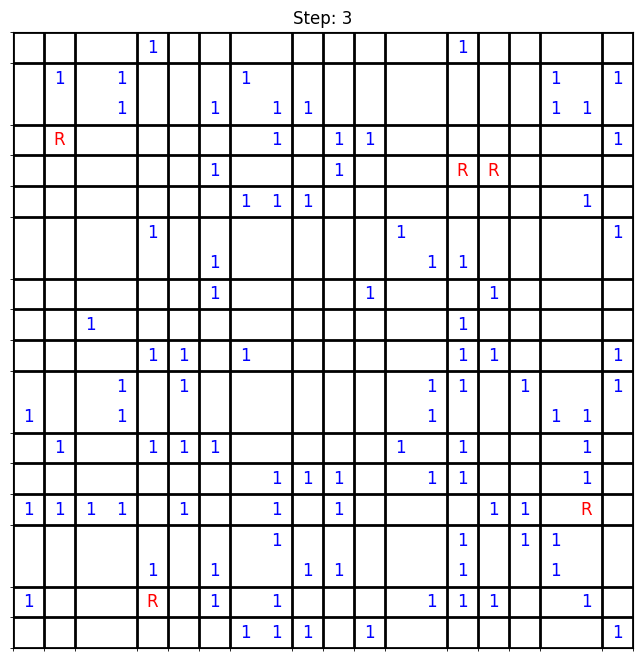

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks(np.arange(-0.5, 20, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 20, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

def update(frame):
    if model.running:
        model.step()
        ax.clear()
        ax.set_xticks(np.arange(-0.5, 20, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, 20, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

        for x in range(model.grid.width):
            for y in range(model.grid.height):
                if model.boxes[x, y] > 0:
                    ax.text(x, y, str(model.boxes[x, y]), va='center', ha='center', fontsize=12, color='blue')

        for agent in model.schedule.agents:
            x, y = agent.pos
            ax.text(x, y, 'R', va='center', ha='center', fontsize=12, color='red')

        ax.set_title(f'Step: {model.current_iteration}')

anim = FuncAnimation(fig, update, frames=MAX_ITERATIONS, repeat=False)
HTML(anim.to_jshtml())

In [18]:
steps=0
while model.running and steps<MAX_ITERATIONS:
    model.step()
    steps+=1
print("Número de pasos totales = ", steps)

Número de pasos totales =  3950
